## from_deeponet-fno.ipynb

The forward problem is based on Poisson equation, and the map of interest is the one that takes Dirichlet boundary condition function to the solution of the PDE. The dmain is a triangular with a notch. The numerical solution and the implementation in Matlab is from the repository [deeponet-fno](https://github.com/lu-group/deeponet-fno/tree/main).

> For the implementation, we only need `Darcy_Triangulation.mat` which is included in the repository. 

> Dependencies can be installed using `neuralop.yml` file in the root directory of this repository. 

Notebook shows the implemntation of DeepONet from the directory [deeponet-fno/src/darcy_triangular_notch
/deeponet](https://github.com/lu-group/deeponet-fno/tree/main/src/darcy_triangular_notch/deeponet) of [deeponet-fno](https://github.com/lu-group/deeponet-fno/tree/main) library. We made few minor changes but the core implementation is from the mentioned source. The method is based on tensorflow `tensorflow.compat.v1`.

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
# import tensorflow as tf

import numpy as np
import scipy.io as io
import sys
import os
import time
np.random.seed(1234)

import matplotlib.pyplot as plt
import scipy

# set seed
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

2024-11-03 16:53:30.934522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 16:53:30.953805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 16:53:30.959562: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 16:53:30.972799: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data_folder = 'data/'
result_folder = 'Results_first_method/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + result_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Utilities function

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

def field_plot(ax, fn_nodal_values, nodes, elements = None, dim = 2, \
                        add_displacement_to_nodes = False, \
                        is_displacement = False, \
                        dbg_log = False, **kwargs):
    
    if dim != 2:
        raise ValueError("Only 2D plots are supported")
    
    if dbg_log:
        print('fn_nodal_values.shape = {}, nodes.shape = {}'.format(fn_nodal_values.shape, \
                                                                nodes.shape))
    
    n1, n2 = len(fn_nodal_values), 1
    if fn_nodal_values.ndim == 2:
        n2 = fn_nodal_values.shape[1]
    elif fn_nodal_values.ndim > 2: 
        raise ValueError("fn_nodal_values should be a 1D or 2D array")

    if n1 != nodes.shape[0]:
        raise ValueError("Number of nodes in the mesh and the number of dofs do not match")
    
    # Compute magnitude of the field
    C = None
    if fn_nodal_values.ndim == 1:
        C = fn_nodal_values[:]**2
    else:
        for i in range(n2):
            if i == 0:
                C = fn_nodal_values[:, i]**2
            else:
                C += fn_nodal_values[:, i]**2

    C = np.sqrt(C)

    # manipulate the configuration of the plot
    nodes_def = nodes
    if is_displacement:
        if n2 != 2:
            raise ValueError("Displacement should be a 2D array for dim = 2")

        if add_displacement_to_nodes:
            nodes_def = nodes + fn_nodal_values

    if dbg_log:
        print('nodes_def.shape = {}'.format(nodes_def.shape))
    
    triang = None
    if elements is not None:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1], elements)
    else:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1])

    shading = kwargs.pop("shading", "gouraud") # or 'shading', 'flat'

    cbar = ax.tripcolor(triang, C, shading=shading, **kwargs)

    return cbar

## Define network methods

In [4]:
class DataSet:
    def __init__(self, bs, num_train = 1900, num_test = 100, \
                 inp_grid_points = 101, out_grid_points = 2397):
        self.bs = bs
        self.num_train = num_train
        self.num_test = num_test
        self.inp_grid_points = inp_grid_points
        self.out_grid_points = out_grid_points

        self.data, self.X_trunk, self.F_train, self.U_train, \
            self.F_test, self.U_test, self.u_train_mean, self.u_train_std = self.load_data()

    def decoder(self, x):
        
        x = x*(self.u_train_std + 1.0e-9) + self.u_train_mean
        return x
    
    def decoder_1d(self, x):

        # assume x is 1D array
        x[:] = x[:]*(self.u_train_std[0,:,0] + 1.0e-9) + self.u_train_mean[0,:,0]
        return x

    def load_data(self):
        
        data = io.loadmat(data_folder + 'Darcy_Triangular')

        xx = data['xx']
        yy = data['yy']
        xx = np.reshape(xx, (-1, 1))
        yy = np.reshape(yy, (-1, 1))
        X_trunk = np.hstack((xx, yy))
        
        f_train = data['f_bc'][:self.num_train,:]
        u_train = data['u_field'][:self.num_train,:]

        f_test = data['f_bc'][self.num_train:(self.num_train + self.num_test),:]
        u_test = data['u_field'][self.num_train:(self.num_train + self.num_test),:]
        
        f_train_mean = np.mean(np.reshape(f_train, (-1, self.inp_grid_points)), 0)
        f_train_std = np.std(np.reshape(f_train, (-1, self.inp_grid_points)), 0)
        u_train_mean = np.mean(np.reshape(u_train, (-1, self.out_grid_points)), 0)
        u_train_std = np.std(np.reshape(u_train, (-1, self.out_grid_points)), 0)
        
        f_train_mean = np.reshape(f_train_mean, (-1, 1, self.inp_grid_points))
        f_train_std = np.reshape(f_train_std, (-1, 1, self.inp_grid_points))
        u_train_mean = np.reshape(u_train_mean, (-1, self.out_grid_points, 1))
        u_train_std = np.reshape(u_train_std, (-1, self.out_grid_points, 1))

        F_train = np.reshape(f_train, (-1, 1, self.inp_grid_points))
        F_train = (F_train - f_train_mean)/(f_train_std + 1.0e-9)       
        U_train = np.reshape(u_train, (-1, self.out_grid_points, 1))
        U_train = (U_train - u_train_mean)/(u_train_std + 1.0e-9)

        F_test = np.reshape(f_test, (-1, 1, self.inp_grid_points))
        F_test = (F_test - f_train_mean)/(f_train_std + 1.0e-9)
        U_test = np.reshape(u_test, (-1, self.out_grid_points, 1))
        U_test = (U_test - u_train_mean)/(u_train_std + 1.0e-9)
        
        return data, X_trunk, F_train, U_train, F_test, U_test, u_train_mean, u_train_std
        
    def minibatch(self):

        batch_id = np.random.choice(self.F_train.shape[0], self.bs, replace=False)

        f_train = [self.F_train[i:i+1] for i in batch_id]
        f_train = np.concatenate(f_train, axis=0)
        u_train = [self.U_train[i:i+1] for i in batch_id]
        u_train = np.concatenate(u_train, axis=0)

        x_train = self.X_trunk
        Xmin = np.array([ 0.,  0.]).reshape((-1, 2))
        Xmax = np.array([ 1.,  1.]).reshape((-1, 2))

        return x_train, f_train, u_train, Xmin, Xmax

    def testbatch(self, num_test):
        batch_id = np.arange(num_test)
        f_test = [self.F_test[i:i+1] for i in batch_id]
        f_test = np.concatenate(f_test, axis=0)
        u_test = [self.U_test[i:i+1] for i in batch_id]
        u_test = np.concatenate(u_test, axis=0)
        x_test = self.X_trunk

        return x_test, f_test, u_test

In [5]:
class FNN:
    def __init__(self):
        pass
    
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2./(in_dim + out_dim))
            weight = tf.Variable(tf.random_normal(shape=[in_dim, out_dim], stddev=std))
            bias = tf.Variable(tf.zeros(shape=[1, out_dim]))
            W.append(weight)
            b.append(bias)

        return W, b

    def fnn_T(self, W, b, X, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        L = len(W)
        for i in range(L-1):
            A = tf.nn.leaky_relu(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y
    
    def fnn_B(self, W, b, X):
        A = X
        L = len(W)
        for i in range(L-1):
            A = tf.nn.leaky_relu(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y

In [6]:
class SaveData:
    def __init__(self):
        pass

    def save(self, sess, x_pos, fnn_model, W_T, b_T, W_B, b_B, Xmin, Xmax, f_ph, u_ph, data, num_test, results_dir):
        
        x_test, f_test, u_test = data.testbatch(num_test)
        x = tf.tile(x_pos[None, :, :], [num_test, 1, 1])
        u_T = fnn_model.fnn_T(W_T, b_T, x, Xmin, Xmax)
        test_dict = {f_ph: f_test, u_ph: u_test}
        u_B = fnn_model.fnn_B(W_B, b_B, f_ph)
        u_B = tf.tile(u_B, [1, x_test.shape[0], 1])
        u_nn = u_B*u_T
        u_pred = tf.reduce_sum(u_nn, axis=-1, keepdims=True)
        u_pred_ = sess.run(u_pred, feed_dict=test_dict)
        u_test = data.decoder(u_test)
        u_pred_ = data.decoder(u_pred_)   

        f_test = np.reshape(f_test, (f_test.shape[0], -1))
        u_pred_ = np.reshape(u_pred_, (u_test.shape[0], u_test.shape[1]))        
        U_ref = np.reshape(u_test, (u_test.shape[0], u_test.shape[1]))
        err = np.mean(np.linalg.norm(u_pred_ - U_ref, 2, axis=1)/np.linalg.norm(U_ref, 2, axis=1))
        print('Relative L2 Error: %.3f'%(err))
        err = np.reshape(err, (-1, 1))
        np.savetxt(results_dir+'/err.txt', err, fmt='%e')
        
        scipy.io.savemat(results_dir+'darcy_triangular_test_DeepONet.mat', 
                     mdict={'x_test': f_test,
                            'y_test': u_test, 
                            'y_pred': u_pred_})

## Define and run the model

In [7]:
num_train = 1900
num_test = 100

inp_grid_points = 101 # number of grid points for the input function
out_grid_points = 2397 # number of evaluations points for the output function
num_br_tr_outputs = 100 # number of outputs from the branch and trunk networks before they are multiplied

#branch net
layer_B = [inp_grid_points, 128, 128, num_br_tr_outputs]
#trunk net
layer_T = [2, 128, 128, num_br_tr_outputs]

#batch_size
bs = 100
epochs = 10000
lr = 1.0e-3

data = DataSet(bs, num_train = num_train, num_test = num_test, inp_grid_points = inp_grid_points, out_grid_points = out_grid_points)

In [8]:
x_train, f_train, u_train, Xmin, Xmax = data.minibatch()
x_pos = tf.constant(x_train, dtype=tf.float32)
x = tf.tile(x_pos[None, :, :], [bs, 1, 1]) #[bs, x_num, x_dim]

f_ph = tf.placeholder(shape=[None, 1, inp_grid_points], dtype=tf.float32) #[bs, f_dim]
u_ph = tf.placeholder(shape=[None, out_grid_points, 1], dtype=tf.float32) #[bs, x_num, 1]
learning_rate = tf.placeholder(tf.float32, shape=[])

fnn_model = FNN()
# Branch net
W_B, b_B = fnn_model.hyper_initial(layer_B)
u_B = fnn_model.fnn_B(W_B, b_B, f_ph)
u_B = tf.tile(u_B, [1, out_grid_points, 1])   
#Trunk net
W_T, b_T = fnn_model.hyper_initial(layer_T)
u_T = fnn_model.fnn_T(W_T, b_T, x, Xmin, Xmax)
#inner product
u_nn = u_B*u_T
u_pred = tf.reduce_sum(u_nn, axis=-1, keepdims=True)

loss = tf.reduce_mean(tf.square(u_ph - u_pred))
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
saver = tf.train.Saver()
sess = tf.Session()  
sess.run(tf.global_variables_initializer())

n = 0
start_time = time.perf_counter()

train_loss = np.zeros((epochs+1, 1))
test_loss = np.zeros((epochs+1, 1))    

loss_print_freq = 100

while n <= epochs:
            
    start_time = time.perf_counter()
    x_train, f_train, u_train, _, _ = data.minibatch()
    train_dict={f_ph: f_train, u_ph: u_train, learning_rate: lr}
    loss_, _ = sess.run([loss, train], feed_dict=train_dict)
    
    x_test, f_test, u_test = data.testbatch(bs)
    u_test_ = sess.run(u_pred, feed_dict={f_ph: f_test})
    u_test = data.decoder(u_test)
    u_test_ = data.decoder(u_test_)
    err = np.mean(np.linalg.norm(u_test_ - u_test, 2, axis=1)/np.linalg.norm(u_test, 2, axis=1))
    
    end_time = time.perf_counter()

    epoch_time = end_time - start_time

    if n % loss_print_freq == 0:
        print('='*30)
        print('Epoch: {:5d}, Train Loss (rel l2): {:.3e}, Test Loss (rel l2): {:.3e}, Time (sec): {:.3f}'.format(n, loss_, err, epoch_time))
        print('='*30)

    train_loss[n,0] = loss_
    test_loss[n,0] = err
    n += 1

I0000 00:00:1730678014.524013   82353 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730678014.575730   82353 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730678014.576006   82353 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730678014.580191   82353 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch:     0, Train Loss (rel l2): 9.709e-01, Test Loss (rel l2): 8.329e-01, Time (sec): 0.365
Epoch:   100, Train Loss (rel l2): 4.614e-02, Test Loss (rel l2): 1.640e-01, Time (sec): 0.044
Epoch:   200, Train Loss (rel l2): 3.864e-02, Test Loss (rel l2): 1.356e-01, Time (sec): 0.044
Epoch:   300, Train Loss (rel l2): 3.326e-02, Test Loss (rel l2): 1.388e-01, Time (sec): 0.045
Epoch:   400, Train Loss (rel l2): 1.941e-02, Test Loss (rel l2): 1.101e-01, Time (sec): 0.044
Epoch:   500, Train Loss (rel l2): 2.263e-02, Test Loss (rel l2): 1.227e-01, Time (sec): 0.044
Epoch:   600, Train Loss (rel l2): 2.302e-02, Test Loss (rel l2): 1.022e-01, Time (sec): 0.044
Epoch:   700, Train Loss (rel l2): 2.177e-02, Test Loss (rel l2): 1.114e-01, Time (sec): 0.044
Epoch:   800, Train Loss (rel l2): 1.999e-02, Test Loss (rel l2): 1.247e-01, Time (sec): 0.044
Epoch:   900, Train Loss (rel l2): 1.783e-02, Test Loss (rel l2): 1.089e-01, Time (sec): 0.045
Epoch:  1000, Train Loss (rel l2): 2.028e-02, Test

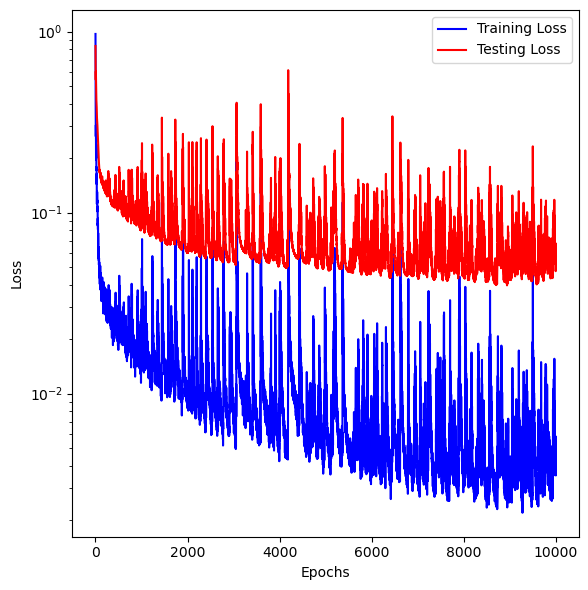

In [9]:
## Plotting the loss history
num_epoch = train_loss.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, train_loss[:,0], color='blue', label='Training Loss')
ax.plot(x, test_loss[:,0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

In [10]:
save_models_to = results_dir +"model/"
if not os.path.exists(save_models_to):
    os.makedirs(save_models_to)      

#    sess.run(tf.global_variables_initializer())
saver.save(sess, save_models_to+'Model')

stop_time = time.perf_counter()
print('Elapsed time (secs): %.3f'%(stop_time - start_time))
    
np.savetxt(results_dir+'/train_loss.txt', train_loss)
np.savetxt(results_dir+'/test_loss.txt', test_loss)

data_save = SaveData()
num_test = 20
data_save.save(sess, x_pos, fnn_model, W_T, b_T, W_B, b_B, Xmin, Xmax, f_ph, u_ph, data, num_test, results_dir)

Elapsed time (secs): 1.534
Relative L2 Error: 0.057


## Test and plot the output of network

In [11]:
test_trunk_inp, test_branch_inp, test_out = data.testbatch(bs)
test_pred = sess.run(u_pred, feed_dict={f_ph: test_branch_inp})

error = np.mean(np.linalg.norm(test_pred - test_out, 2, axis=1)/np.linalg.norm(test_out, 2, axis=1))

print('test_out shape: {}, test_pred shape: {}'.format(test_out.shape, test_pred.shape))

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 2397, 1), test_pred shape: (100, 2397, 1)
Num tests:    20, Mean Loss (rel l2): 6.843e-02, Std Loss (rel l2): 0.000e+00


i_plot =     0, error (rel l2): 5.323e-02
i_plot =     1, error (rel l2): 5.953e-02
i_plot =     2, error (rel l2): 4.423e-02
i_plot =     3, error (rel l2): 3.830e-02
i_plot =     4, error (rel l2): 6.450e-02
i_plot =     5, error (rel l2): 6.165e-02
i_plot =     6, error (rel l2): 7.922e-02
i_plot =     7, error (rel l2): 4.640e-02
i_plot =     8, error (rel l2): 4.503e-02
i_plot =     9, error (rel l2): 5.247e-02
i_plot =    10, error (rel l2): 8.161e-02
i_plot =    11, error (rel l2): 7.191e-02
i_plot =    12, error (rel l2): 4.357e-02
i_plot =    13, error (rel l2): 7.175e-02
i_plot =    14, error (rel l2): 5.268e-02
i_plot =    15, error (rel l2): 5.484e-02


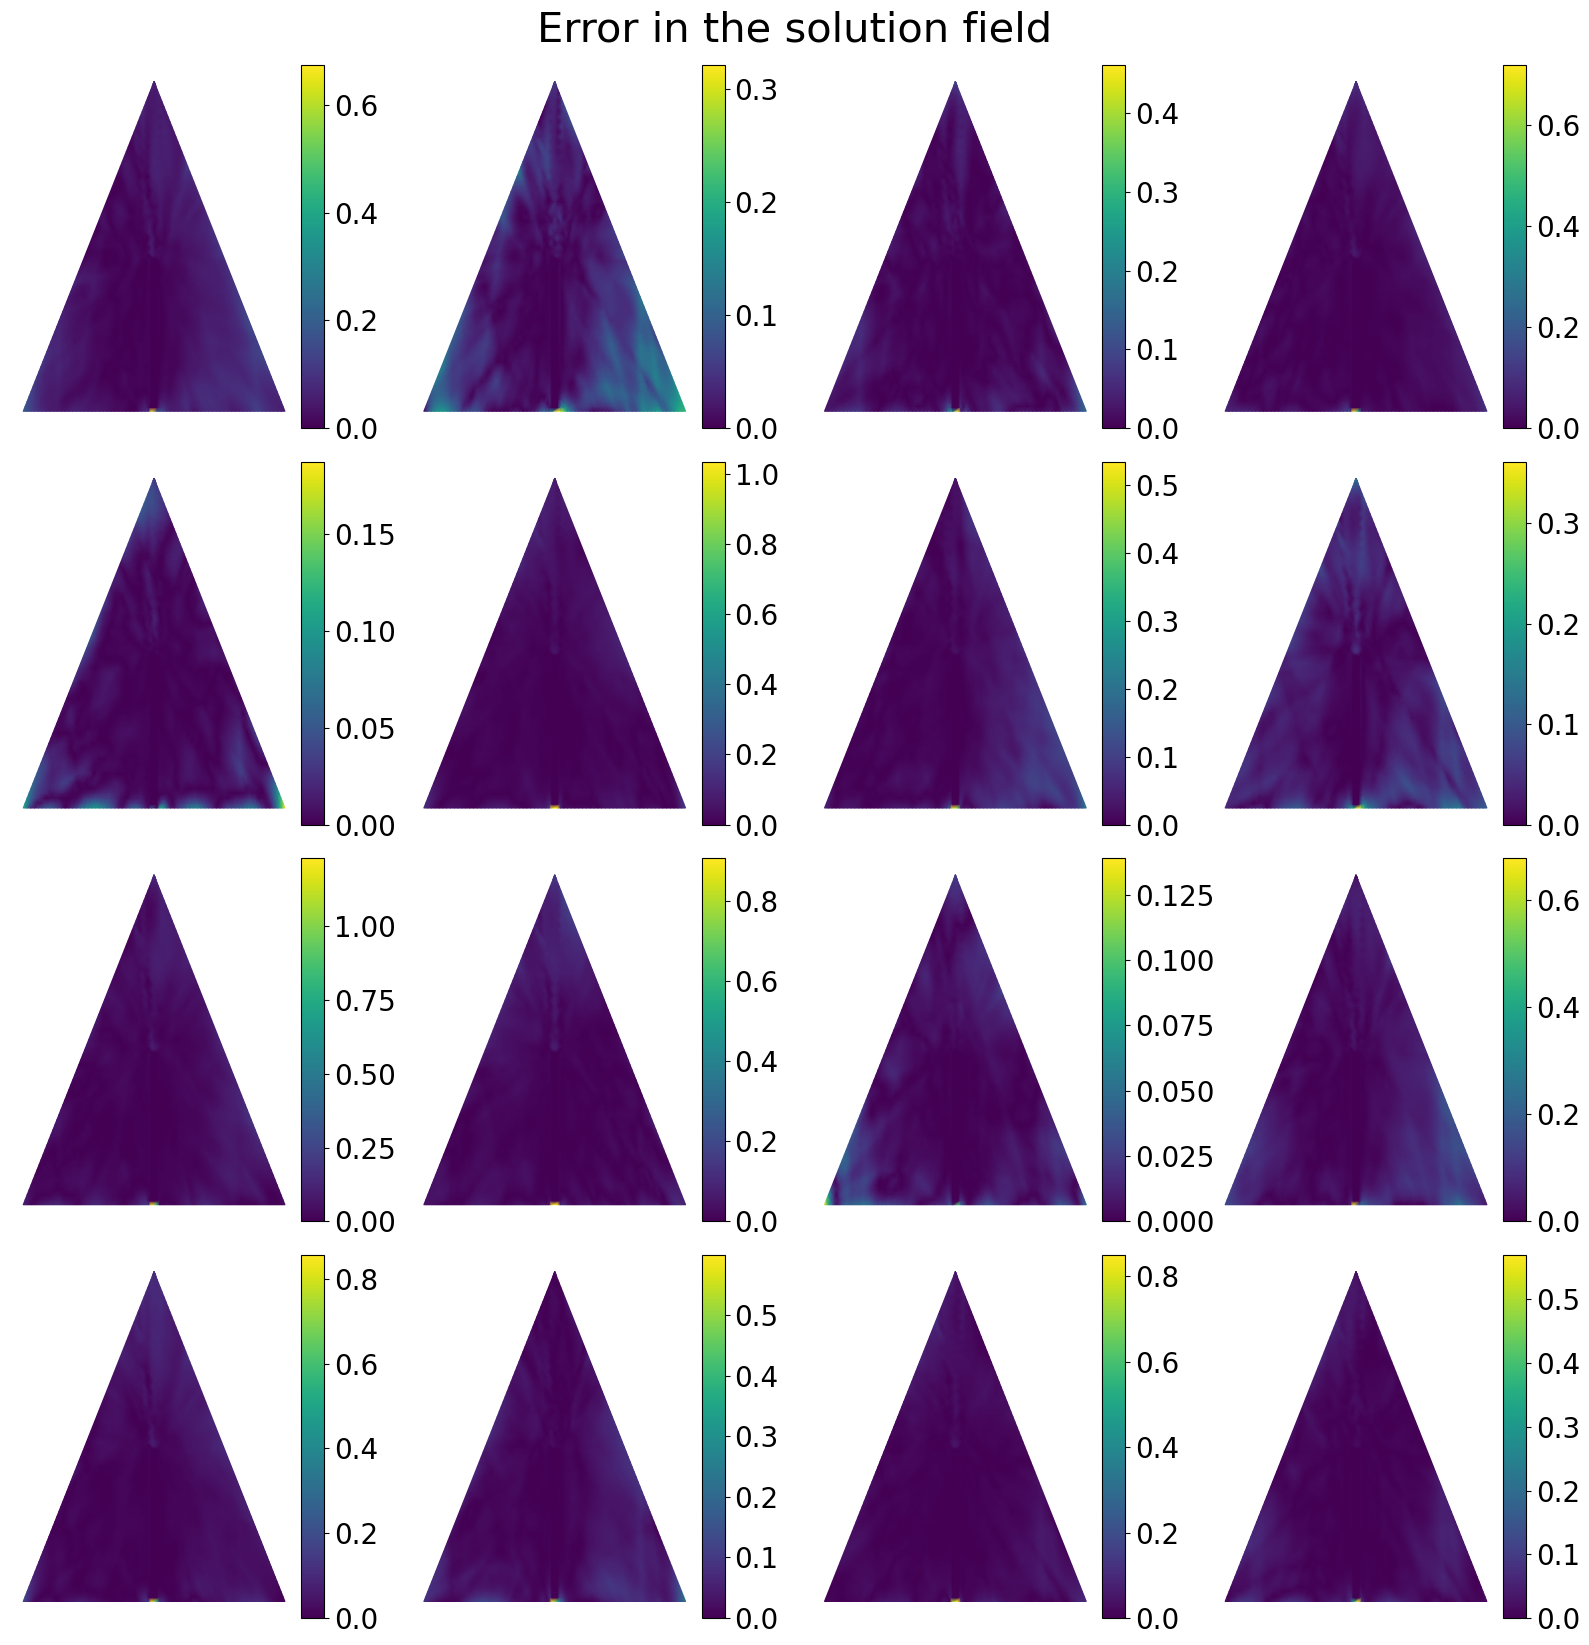

In [12]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 16))

decode = True

for i in range(rows):
    for j in range(cols):
        i_plot = i*cols + j

        i_pred = test_pred[i_plot, :, 0]
        i_truth = test_out[i_plot, :, 0]
        if decode:
            i_pred = data.decoder_1d(i_pred)
            i_truth = data.decoder_1d(i_truth)
            
        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = test_trunk_inp

        cbar = field_plot(axs[i,j], i_diff, nodes)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        axs[j,i].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()
